#  Deep Learning for Super Resolution on DestinE Climate Data

Destine Login

In [1]:
%%capture cap
%run auth/cacheb-authentication.py

In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Import dependencies

In [3]:
import warnings
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from utils.general import (get_bbox_from_config,
                           load_config, compute_mean_std,
                           create_gif_from_images,
                           save_best_model_as_pt,
                           save_config_to_log_dir)
from data.loaders import load_data
from data.datasets import CreateDataset, StreamCreateDataset
import models.models as models
from trainer import TrainerSr
# Ignore warnings and set precision
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('high')

INFO: Seed set to 42


### 1. Load Configuration

In [4]:
# Load configuration and set seed
config = load_config()
seed_everything(config["training"]["seed"], workers=True)

INFO: Seed set to 42


42

### 2. Load Data and Compute Statistics


In [5]:
# Load bounding box and data
bbox = get_bbox_from_config(config=config)
lr, hr = load_data(config=config)

# Compute mean and standard deviation for normalization
hr_mean, hr_std = compute_mean_std(hr)
lr_mean, lr_std = compute_mean_std(lr)

# Update config with computed mean and std
config["dataset"]["hr_mean"] = hr_mean
config["dataset"]["hr_std"] = hr_std
config["dataset"]["lr_mean"] = lr_mean
config["dataset"]["lr_std"] = lr_std

# Display computed statistics
print(f"HR mean: {hr_mean}, HR std: {hr_std}")
print(f"LR mean: {lr_mean}, LR std: {lr_std}")

HR mean: 10.094209671020508, HR std: 4.23423957824707
LR mean: 10.007193565368652, LR std: 4.303609371185303


### 3. Split Data into Train, Validation, and Test Sets

In [6]:
# Split indices for train, validation, and test sets
batch_size = config['training']['batch_size']
time_indices = np.arange(len(hr.time.values))

train_indices, remaining_indices = train_test_split(
    time_indices, train_size=0.70, shuffle=True, random_state=config["training"]["seed"]
)
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=config["validation"]["val_split_ratio"], shuffle=False, random_state=config["training"]["seed"]
)

# Split datasets into train, validation, and test sets
train_lr, train_hr = lr.isel(time=train_indices), hr.isel(time=train_indices)
val_lr, val_hr = lr.isel(time=val_indices), hr.isel(time=val_indices)
test_lr, test_hr = lr.isel(time=test_indices), hr.isel(time=test_indices)

# Print dataset sizes
print(f"Train samples: {len(train_hr.time.values)}")
print(f"Validation samples: {len(val_hr.time.values)}")
print(f"Test samples: {len(test_hr.time.values)}")


Train samples: 520
Validation samples: 156
Test samples: 68


### 4. Create DataLoader

In [7]:
# Create DataLoader based on streaming preference
if config["training"]["streaming"]:
    train_loader = StreamCreateDataset(hr_data=train_hr, lr_data=train_lr, hr_mean=hr_mean, hr_std=hr_std,
                                       lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
    val_loader = StreamCreateDataset(hr_data=val_hr, lr_data=val_lr, hr_mean=hr_mean, hr_std=hr_std,
                                     lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
    test_loader = StreamCreateDataset(hr_data=test_hr, lr_data=test_lr, hr_mean=hr_mean, hr_std=hr_std,
                                      lr_mean=lr_mean, lr_std=lr_std, batch_size=batch_size)
else:
    train_dataset = CreateDataset(hr_data=train_hr, lr_data=train_lr, hr_mean=hr_mean, hr_std=hr_std,
                                  lr_mean=lr_mean, lr_std=lr_std)
    val_dataset = CreateDataset(hr_data=val_hr, lr_data=val_lr, hr_mean=hr_mean, hr_std=hr_std,
                                lr_mean=lr_mean, lr_std=lr_std)
    test_dataset = CreateDataset(hr_data=test_hr, lr_data=test_lr, hr_mean=hr_mean, hr_std=hr_std,
                                 lr_mean=lr_mean, lr_std=lr_std)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)


### 5. Initialize Model


In [8]:
# Initialize SRResNet model based on config
sr_model = getattr(models, config["model"]["architecture"])
sr_model = sr_model(
    large_kernel_size=config["model"]["large_kernel_size"],
    small_kernel_size=config["model"]["small_kernel_size"],
    n_channels=config["model"]["n_channels"],
    n_blocks=config["model"]["n_blocks"],
    scaling_factor=config["model"]["scaling_factor"]
)

# Wrap model in TrainerSr class
model = TrainerSr(config=config, model=sr_model)

### 6. Set Up Checkpointing and Trainer


In [9]:
# Define checkpoint callback
checkpoint_val_ssim = ModelCheckpoint(
    monitor=config['checkpoint']['monitor'], filename="best-val-ssim-{epoch:02d}-{val_ssim:.2f}",
    save_top_k=1, mode=config['checkpoint']['mode']
)

# Set up the PyTorch Lightning Trainer
trainer = L.Trainer(
    devices=config["training"]["devices"],
    max_epochs=config["training"]["epochs"],
    accelerator=config["training"]["accelerator"],
    deterministic=config["training"]["deterministic"],
    callbacks=[checkpoint_val_ssim],
)


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


### 7. Train the Model


In [10]:
# Train the model
trainer.fit(model, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                              | Params | Mode 
--------------------------------------------------------------------
0 | model | SRResNet                          | 1.7 M  | train
1 | psnr  | _PeakSignalNoiseRatio             | 0      | train
2 | ssim  | _StructuralSimilarityIndexMeasure | 0      | train
--------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.706     Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


### 8. Evaluate and Test the Model


In [11]:
# Load best model checkpoint
best_model_path = checkpoint_val_ssim.best_model_path
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["state_dict"])

# Test the model
trainer.test(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5218148231506348     │
│         test_psnr         │    21.468219757080078     │
│         test_ssim         │    0.5221145153045654     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5218148231506348,
  'test_psnr': 21.468219757080078,
  'test_ssim': 0.5221145153045654}]

### 9. Visualize Results and Save Model


In [12]:
# Generate visualizations and create GIF
create_gif_from_images(trainer=trainer)

# Save best model as .pt file
best_model_path = save_best_model_as_pt(checkpoint_val_ssim, sr_model)

# Save config to log directory
save_config_to_log_dir(log_dir_path=trainer.log_dir, config=config)

GIF saved at /home/ubuntu/project/DestinE_User_Exchange_Super_Resolution/lightning_logs/version_4/val_prediction/training_progress.gif
Best checkpoint path: /home/ubuntu/project/DestinE_User_Exchange_Super_Resolution/lightning_logs/version_4/checkpoints/best-val-ssim-epoch=07-val_ssim=0.51.ckpt
Best model saved as: /home/ubuntu/project/DestinE_User_Exchange_Super_Resolution/lightning_logs/version_4/checkpoints/best-val-ssim-epoch=07-val_ssim=0.51.pt
Configuration file saved to: /home/ubuntu/project/DestinE_User_Exchange_Super_Resolution/lightning_logs/version_4/config.json


### 10. Inference

2024-10-25 13:29:38.388 | INFO     | inference:load_model:37 - Loading checkpoint from /home/ubuntu/project/DestinE_User_Exchange_Super_Resolution/lightning_logs/version_4/checkpoints/best-val-ssim-epoch=07-val_ssim=0.51.pt
2024-10-25 13:29:38.409 | INFO     | inference:__init__:24 - Model loaded and moved to device: cuda
2024-10-25 13:29:38.412 | INFO     | inference:preprocess:61 - Preprocessing data with mean=10.007193565368652, std=4.303609371185303


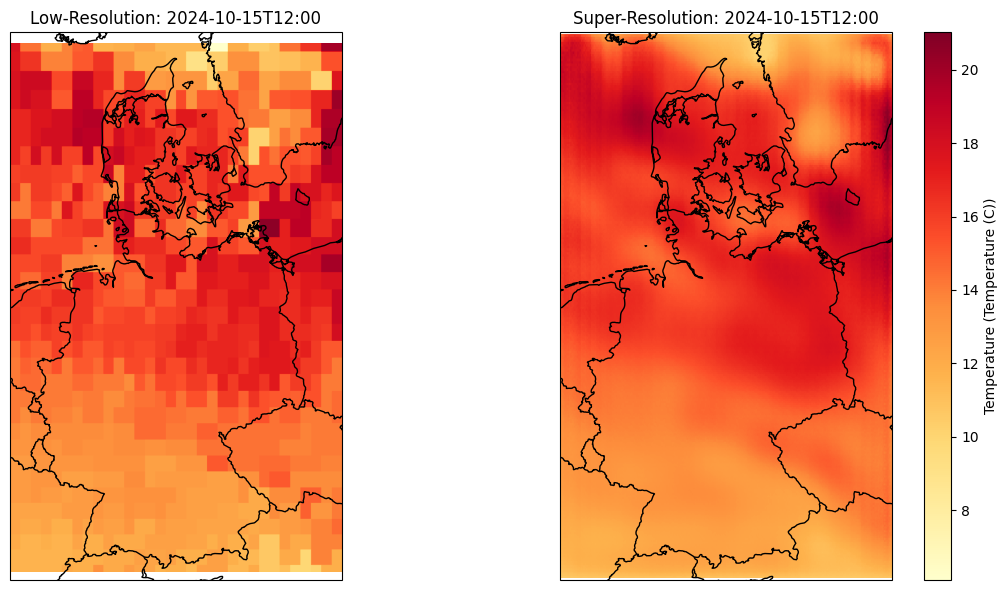

In [13]:
from inference import SuperResolutionInference
sr_model = getattr(models, config["model"]["architecture"])
sr_model = sr_model(
    large_kernel_size=config["model"]["large_kernel_size"],
    small_kernel_size=config["model"]["small_kernel_size"],
    n_channels=config["model"]["n_channels"],
    n_blocks=config["model"]["n_blocks"],
    scaling_factor=config["model"]["scaling_factor"]
)
# Initialize the inference class
sr = SuperResolutionInference(model_path=best_model_path, model_class=sr_model)

# Load and preprocess a single LR image
lr_image = lr.sel(time="2024-10-15T12:00:00")
preprocessed_image = sr.preprocess(lr_image, lr_mean=lr_mean, lr_std=lr_std)

# Perform inference
sr_result = sr.inference(preprocessed_image)

# Post-process the SR result
sr_result = sr.postprocessing(sr_result, hr_mean, hr_std)
# Visualize the LR and SR images
fig = sr.visualize(lr_image=lr_image, sr_image=sr_result, lr_time=lr_image.time.values)